my comment

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import humanize
sns.set(rc={'figure.figsize':(11,8)})
sns.set(font_scale = 2)

In [78]:
size = [10000000]
files = ["alex", "gregor", "5950x-py3-12-gregor", "pi4-jp", "laptop-jp"]
no_pi_files = ["alex", "gregor", "5950x-py3-12-gregor", "laptop-jp"]
machine = ["MacBookPro i7 2400Mhz","Macbook Pro M1", "PI4", "AMD64 23-113 Win10"]

In [79]:
def generate_average(df, tag=None, size=None, name=None):
    _df = df.loc[(df['name'] == name) & (df['tag'] == tag) &  (df['size'] == size) ]
    avg = _df.groupby(['processors', 'name', 'size', 'tag']).mean()
    avg['tag'] = tag
    avg['name'] = name
    return avg

In [80]:
def plot_benchmark_by_size(df, size=None, tag=None, files=None, x="processors", y="time"):
    names = "-".join(files)
    sns.lineplot(data=df, x=x, y=y, hue="name");
    t = tag.title()
    h_size = humanize.intword(size[0])
    label = f"{t}, Size={h_size}".replace("_", " ")
    plt.title(f"{label}")
    if "time" in y: y = f"{y}/s"
    if "time" in x: x = f"{x}/s"
    plt.xlabel(x.capitalize())
    plt.ylabel(y.capitalize())
    plt.savefig(f"images/by-size-{size}-{tag}-{names}.png")
    plt.savefig(f"images/by-size-{size}-{tag}-{names}.pdf")

In [81]:
def get_data(content, tag="multiprocessing_mergesort", size=None, log=None):
    """
    TBD

    :param content: data output from running mergesort
    :type content: string
    :return: none
    :rtype: none
    """
    found = []
    lines = [line for line in content if "# csv" in line]

    for line in lines[1:]:
        entries = line.split(",")
        entry = [entries[a] for a in [1, 3, 9, 8]]
        time = entry[1]
        name = f"{entry[2]}-{entry[3]}"

        processes, size, count = entry[0].split(tag)[1].split("_")[1:]

        entry = [
            int(processes),
            # int(count),
            float(time),
            int(size),
            name,
            tag
        ]
        found.append(entry)
    return found

In [82]:
def read_log(log, size=None, tag="multiprocessing_mergesort"):
    if ".log" not in log:
        log = f"log/{log}-{size}.log"
    f = open(log, "r")
    content = f.read().splitlines()
    try:
        data = get_data(content, tag=tag, size=size, log=log)
    except:
        print("ERROR READING", log)
    return data


In [83]:
def read_logs(files=None, size =[100], tag=["multiprocessing_mergesort"]):
    data = []
    for file in files:
        for s in size:
            content = read_log(file, size=s, tag="multiprocessing_mergesort")
            data = data + content
    #for i in range(0,len(data)):
    #    data[i] = [i] + data[i]
    df = pd.DataFrame(data)
    df.columns = ['processors', 'time', 'size', 'name', 'tag']
    return df

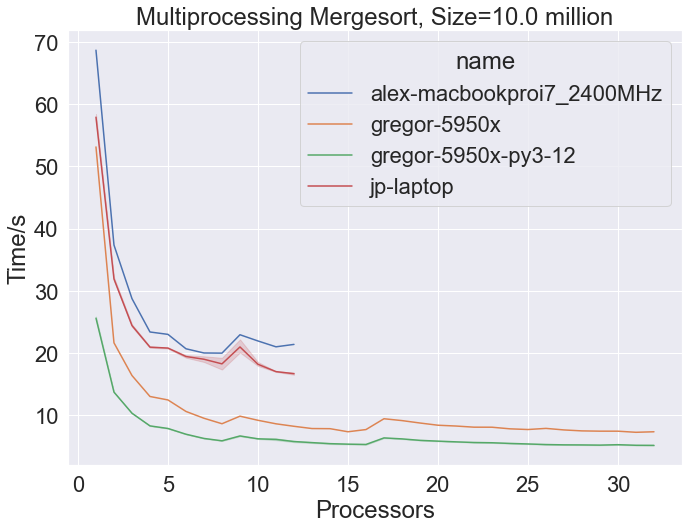

In [84]:
df = read_logs(files=no_pi_files, size=size)
plot_benchmark_by_size(df, size, "multiprocessing_mergesort", files)
plt.show()

In [85]:
df = read_logs(files=files, size=size)
df

,processors,time,size,name,tag
0,12,21.369,10000000,alex-macbookproi7_2400MHz,multiprocessing_mergesort
1,11,20.981,10000000,alex-macbookproi7_2400MHz,multiprocessing_mergesort
2,10,21.921,10000000,alex-macbookproi7_2400MHz,multiprocessing_mergesort
3,9,22.923,10000000,alex-macbookproi7_2400MHz,multiprocessing_mergesort
4,8,19.963,10000000,alex-macbookproi7_2400MHz,multiprocessing_mergesort
...,...,...,...,...,...
519,1,58.239,10000000,jp-laptop,multiprocessing_mergesort
520,1,57.243,10000000,jp-laptop,multiprocessing_mergesort
521,1,58.195,10000000,jp-laptop,multiprocessing_mergesort
522,1,59.450,10000000,jp-laptop,multiprocessing_mergesort


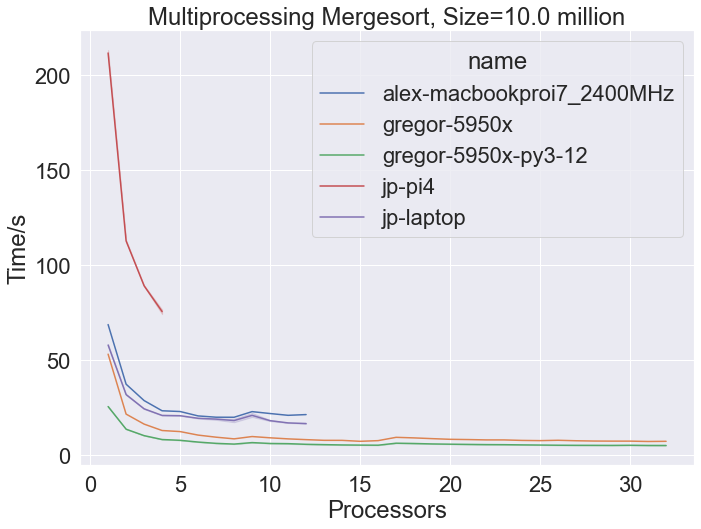

In [86]:
    plot_benchmark_by_size(df, size, "multiprocessing_mergesort", files)
    plt.show()

In [87]:
# calculate the avarage of all data with the same repeat
# find the smalless time for 1 processor for the specific machine and processors. Use that to devide them. you will have many devisions, and you need to selectively apply this
# then the df has just as the original df a range of efficiencies and speedups, e.g. a band

#technicalle ye can do the average, but may be easier to jsut do the band and not worry about average as the plot does it.


In [88]:
def find_speedup(name_of_cpu):
    df2 = df[df.name == name_of_cpu]
    time_for_one_processor = df2.loc[df2.processors==1,'time']
    df2["speedup"] = df["time"]/time_for_one_processor
    list_of_times = df2['time'].tolist()
    speedup_list = []
    for time in list_of_times:
        speedup = list_of_times[-1]/time
        speedup_list.append(speedup)
    rounded_speedup = list(np.around(np.array(speedup_list),3))
    df2["speedup"] = rounded_speedup
    list_of_speedup = df2['speedup'].tolist()
    list_of_processors = df2['processors'].tolist()
    list_of_efficiency = []
    counter = 0
    for speedup in list_of_speedup:
        efficiency = speedup / list_of_processors[counter]
        counter += 1
        list_of_efficiency.append(efficiency)
    rounded_efficiency = list(np.around(np.array(list_of_efficiency),3))
    df2["efficiency"] = rounded_efficiency
    return df2

In [89]:
fixed_dataframe = find_speedup('alex-macbookproi7_2400MHz')
files = ["gregor-5950x-py3-12", "jp-pi4", "jp-laptop", "alex-macbookproi7_2400MHz", "gregor-5950x"]
df_with_speedup = pd.DataFrame()
for name in files:
    df_to_be_appended = find_speedup(name)
    df_with_speedup = pd.concat([df_with_speedup, df_to_be_appended], axis=0)


C:\Users\Sledgehammer\AppData\Local\Temp\ipykernel_40048\1409089586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["speedup"] = df["time"]/time_for_one_processor
C:\Users\Sledgehammer\AppData\Local\Temp\ipykernel_40048\1409089586.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["speedup"] = rounded_speedup
C:\Users\Sledgehammer\AppData\Local\Temp\ipykernel_40048\1409089586.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [90]:
print(df_with_speedup.to_string())

     processors     time      size                       name                        tag  speedup  efficiency
44           32    5.138  10000000        gregor-5950x-py3-12  multiprocessing_mergesort    5.013       0.157
45           32    5.053  10000000        gregor-5950x-py3-12  multiprocessing_mergesort    5.097       0.159
46           32    5.185  10000000        gregor-5950x-py3-12  multiprocessing_mergesort    4.967       0.155
47           32    5.128  10000000        gregor-5950x-py3-12  multiprocessing_mergesort    5.022       0.157
48           32    5.126  10000000        gregor-5950x-py3-12  multiprocessing_mergesort    5.024       0.157
49           32    5.159  10000000        gregor-5950x-py3-12  multiprocessing_mergesort    4.992       0.156
50           32    5.194  10000000        gregor-5950x-py3-12  multiprocessing_mergesort    4.959       0.155
51           32    5.176  10000000        gregor-5950x-py3-12  multiprocessing_mergesort    4.976       0.156
52        

In [91]:

df_with_speedup


,processors,time,size,name,tag,speedup,efficiency
44,32,5.138,10000000,gregor-5950x-py3-12,multiprocessing_mergesort,5.013,0.157
45,32,5.053,10000000,gregor-5950x-py3-12,multiprocessing_mergesort,5.097,0.159
46,32,5.185,10000000,gregor-5950x-py3-12,multiprocessing_mergesort,4.967,0.155
47,32,5.128,10000000,gregor-5950x-py3-12,multiprocessing_mergesort,5.022,0.157
48,32,5.126,10000000,gregor-5950x-py3-12,multiprocessing_mergesort,5.024,0.157
...,...,...,...,...,...,...,...
39,5,12.434,10000000,gregor-5950x,multiprocessing_mergesort,4.273,0.855
40,4,12.992,10000000,gregor-5950x,multiprocessing_mergesort,4.089,1.022
41,3,16.364,10000000,gregor-5950x,multiprocessing_mergesort,3.247,1.082
42,2,21.622,10000000,gregor-5950x,multiprocessing_mergesort,2.457,1.228


In [92]:
'''color = ["red", "green", "blue"]
files = ["gregor-5950x-py3-12", "jp-pi4", "jp-laptop", "alex-macbookproi7_2400MHz"]
counter = 0
for name in files:
    print(name)
    a = df[df["name"] == name]
    minimum_processor = a[a["processors"] == 1]
    display(a)
    minimum_time = min(minimum_processor["time"])
    a["minimum_time"] = minimum_time
    a["speedup"] = a["minimum_time"]/a["time"]
    plot_benchmark_by_size(a, size, "multiprocessing_mergesort", files, y="speedup")
    counter+=1
plt.show()'''

'color = ["red", "green", "blue"]\nfiles = ["gregor-5950x-py3-12", "jp-pi4", "jp-laptop", "alex-macbookproi7_2400MHz"]\ncounter = 0\nfor name in files:\n    print(name)\n    a = df[df["name"] == name]\n    minimum_processor = a[a["processors"] == 1]\n    display(a)\n    minimum_time = min(minimum_processor["time"])\n    a["minimum_time"] = minimum_time\n    a["speedup"] = a["minimum_time"]/a["time"]\n    plot_benchmark_by_size(a, size, "multiprocessing_mergesort", files, y="speedup")\n    counter+=1\nplt.show()'

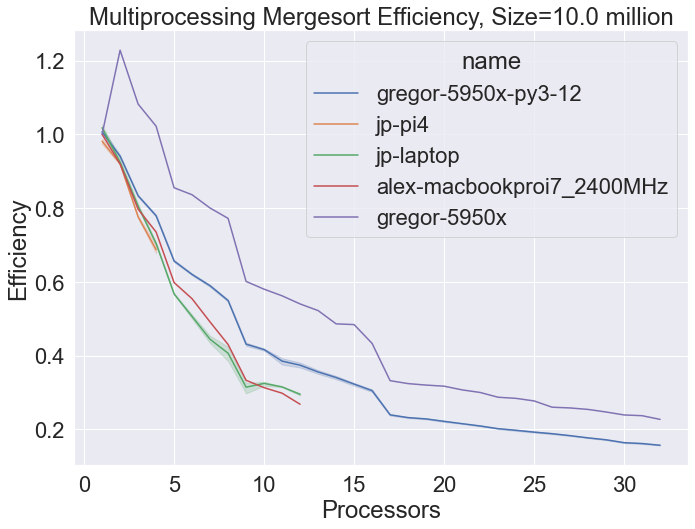

In [93]:
plot_benchmark_by_size(df_with_speedup, size, "multiprocessing_mergesort efficiency", files, y="efficiency")

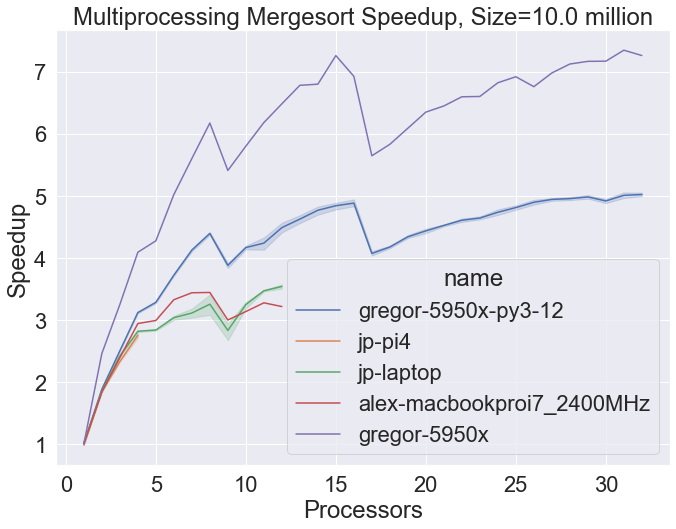

In [94]:
    plot_benchmark_by_size(df_with_speedup, size, "multiprocessing_mergesort speedup", files, y="speedup")
    plt.show()

In [95]:

plot_benchmark_by_size(df, size, "multiprocessing_mergesort", files, y="efficiency")
plt.show()

ValueError: Could not interpret value `efficiency` for parameter `y`

In [ ]:
# calculate the speedup
df_with_speedup['speedup']

In [ ]:
# calculate the efficiency
df_with_speedup['efficiency']

In [ ]:
# produce the plots
...

In [ ]:
def calculate_speedup(size):
    tag = "multiprocessing_mergesort"
    data = []

    for file in files:
        try:
            _data = read_log(file, size=size)
            print(f"Read: {file}")
            data = data + _data
        except:
            pass

    # print data
    print(data)

    df = pd.DataFrame(data = data, 
                      columns = ["processors", "time", "size", "name", "tag"])
    # df["speedup"] = df["time"].max()  / df["time"] 
    print(df["time"])

    plot_benchmark_by_size(df, size, tag, files)
    plt.show()
 
    # calculate average
    avg = pd.DataFrame()
    for name in files:
        _df = generate_average(df, tag="multiprocessing_mergesort", name=name, size=size)
        avg = pd.concat([avg, _df])
    print(avg)

    # calculate speedup
    speedup = pd.DataFrame(avg)
    # speedup["p"] = speedup.index.get_level_values(0).astype(float)

    frames = []
    for name in files:
        # select all times with given user name
        df = speedup[speedup['name'] == name]
        time_for_one_processor = df.query('processors == 1').iat[0, 0]
        # calculate speedup by dividing time by time taken using one processor 
        df['speedup'] = df["time"].rdiv(time_for_one_processor)
        frames.append(df)

    result = pd.concat(frames)
    print(result)

    plot_benchmark_by_size(result, size=size, tag=tag, files=files, x="processors", y="speedup")
    plt.show()
    

In [ ]:
calculate_speedup(size)


In [ ]:
def calculate_efficiency(size):
    tag = "multiprocessing_mergesort"
    data = []

    for file in files:
        try:
            _data = read_log(file, size=size)
            data = data + _data
        except:
            pass
    # print data
    print(data)

    df = pd.DataFrame(data = data, 
                      columns = ["processors", "time", "size", "name", "tag"])
    # df["speedup"] = df["time"].max()  / df["time"] 
    print(df["time"])

    plot_benchmark_by_size(df, size, tag, files)
    plt.show()

    # calculate average
    avg = pd.DataFrame()
    for name in files:
        _df = generate_average(df, tag="multiprocessing_mergesort", name=name, size=size)
        avg = pd.concat([avg, _df])
    # print(avg)

    # calculate speedup
    speedup = pd.DataFrame(avg)
    # speedup["p"] = speedup.index.get_level_values(0).astype(float)

    speedup_frames = []
    for name in files:
        # select all times with given user name
        df = speedup[speedup['name'] == name]
        time_for_one_processor = df.query('processors == 1').iat[0, 0]
        # calculate speedup by dividing time by time taken using one processor 
        df['speedup'] = df["time"].rdiv(time_for_one_processor)
        speedup_frames.append(df)

    result = pd.concat(speedup_frames)
    result['p'] = speedup.index.get_level_values(0).astype(float)
    result['efficiency'] = result['speedup'] / result['p']
    # print(result['efficiency'])

    plot_benchmark_by_size(result, size=size, tag=tag, files=files, x="processors", y="efficiency")
    plt.show()
    